In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']  = "0"
os.environ['CUDA_VISIBLE_DEVICES'] 

'0'

In [37]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from transformers import TFBertForSequenceClassification

from pathlib import Path

from nlp import load_dataset
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import ast

import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import sys
#root_project = "/content/Rest/"
root_project = "/storagenfs/a.cudazzo1/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/SaRaH/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_data, set_unkmark_token
from src.utils import metrics
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb
from src.utils.utils import plotHistory, plotF1_macro, plotLoss
from src.utils.metrics import f1_macro



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def read_evalita_split(df):
    texts = []
    labels = []
    for index, row in df.iterrows():
        texts.append(row['tokens'])
        labels.append(row['stereotype'])
    return texts, labels

class EvalitaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Dataset

In [28]:
dataset_dev_path   = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"

df = pd.read_csv(dataset_dev_path, sep='\t')
df = df[['tokens','stereotype']]

df_test = pd.read_csv(dataset_test_tweets_path, sep='\t')
df_test = df_test[['tokens','stereotype']]

In [29]:
X, y = read_evalita_split(df)
#y  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y])
X_test, y_test = read_evalita_split(df_test)
#y_test  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y_test])

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

# Bert tokenizer 

In [34]:
model_name = "dbmdz/bert-base-italian-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [35]:
max_length = 50
X_train_e = tokenizer(X_train, truncation=True, padding=True, max_length = max_length)
X_val_e = tokenizer(X_val, truncation=True, padding=True, max_length = max_length)
X_test_e = tokenizer(X_test, truncation=True, padding=True, max_length = max_length)

# To Tourch dataset

In [36]:
train_dataset = EvalitaDataset(X_train_e, y_train)
val_dataset = EvalitaDataset(X_val_e, y_val)
test_dataset = EvalitaDataset(X_test_e, y_test)

## Tourch loader

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Training

In [10]:
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(model_name)
model.to(device)


optim = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
m = torch.nn.Softmax(dim=1)
min_valid_loss = np.inf
history = {"loss": [],
           "val_loss": [],
           "f1_macro": [],
           "val_f1_macro": []
          }

for epoch in range(3):
    train_loss = 0.0
    train_f1_macro = 0.0
    val_loss = 0.0
    val_f1_macro = 0.0
    model.train()
    for i, batch in enumerate(train_loader, 0):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        # print statistics
        train_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        train_f1_macro += f1_score(batch['labels'], prediction, average="macro")

    
    model.eval()     # Optional when not using Model Specific layer
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        val_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        val_f1_macro += f1_score(batch['labels'], prediction, average="macro")
    
    history["loss"].append(train_loss / len(train_loader))
    history["val_loss"].append(val_loss / len(val_loader))
    history["f1_macro"].append(train_f1_macro / len(train_loader))
    history["val_f1_macro"].append(val_f1_macro / len(val_loader))
    
    print(f'Epoch {epoch+1} \t loss: {train_loss / len(train_loader)} \t val_loss: {val_loss / len(val_loader)} \t f1_macro: {train_f1_macro/len(train_loader)} \t val_f1_macro: {val_f1_macro/len(val_loader)}')
    if min_valid_loss > (val_loss /len(val_loader)):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(val_loss /len(val_loader)):.6f}) \t Saving The Model')
        min_valid_loss = (val_loss / len(val_loader))
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
model.eval()
print()

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.6030602332269936 	 val_loss: 0.5356467785530312 	 f1_macro: 0.6203358380494481 	 val_f1_macro: 0.7110746360072935
Validation Loss Decreased(inf--->0.535647) 	 Saving The Model
Epoch 2 	 loss: 0.43837999663593474 	 val_loss: 0.6540917196246081 	 f1_macro: 0.784880364090212 	 val_f1_macro: 0.6156011996272654
Epoch 3 	 loss: 0.25427655877589045 	 val_loss: 0.6803822635218154 	 f1_macro: 0.8891630037497718 	 val_f1_macro: 0.695664501906328



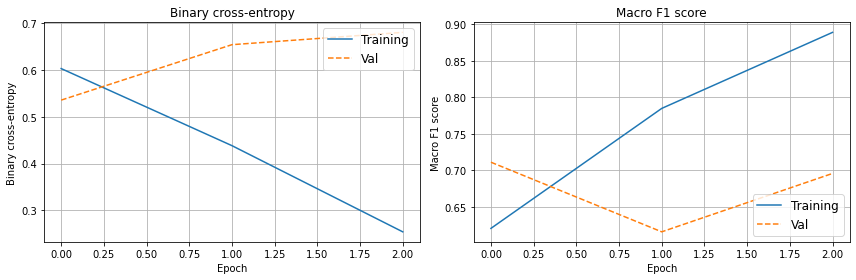

In [11]:
plotHistory(history)

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name)
model.load_state_dict(torch.load('saved_model.pth'))
model.to(device)
print()

In [14]:
model.eval()
m = torch.nn.Softmax(dim=1)
tot_loss = []
prediction = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # calculate outputs by running images through the network
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        prediction += np.argmax(m(outputs["logits"]).cpu().numpy(), axis = 1).tolist()
        tot_loss.append(outputs[0].cpu().numpy())
print(np.mean(tot_loss))

print(f1_score(y_test, prediction, average="macro"))
print(classification_report(y_test, prediction))

0.52492976
0.7406538170823885
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       694
           1       0.70      0.75      0.72       569

    accuracy                           0.74      1263
   macro avg       0.74      0.74      0.74      1263
weighted avg       0.74      0.74      0.74      1263



# Gridsearch

In [ ]:
def get_model(model_name, hyper_param, device):
    model = BertForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    optim = AdamW(model.parameters(), lr=hyper_param["lr"], weight_decay=hyper_param["weight_decay"])
    return model, optim

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

m = torch.nn.Softmax(dim=1)
min_valid_loss = np.inf
history = {"loss": [],
           "val_loss": [],
           "f1_macro": [],
           "val_f1_macro": []
          }

for epoch in range(3):
    train_loss = 0.0
    train_f1_macro = 0.0
    val_loss = 0.0
    val_f1_macro = 0.0
    model.train()
    for i, batch in enumerate(train_loader, 0):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        # print statistics
        train_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        train_f1_macro += f1_score(batch['labels'], prediction, average="macro")

    
    model.eval()     # Optional when not using Model Specific layer
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        val_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        val_f1_macro += f1_score(batch['labels'], prediction, average="macro")
    
    history["loss"].append(train_loss / len(train_loader))
    history["val_loss"].append(val_loss / len(val_loader))
    history["f1_macro"].append(train_f1_macro / len(train_loader))
    history["val_f1_macro"].append(val_f1_macro / len(val_loader))
    
    print(f'Epoch {epoch+1} \t loss: {train_loss / len(train_loader)} \t val_loss: {val_loss / len(val_loader)} \t f1_macro: {train_f1_macro/len(train_loader)} \t val_f1_macro: {val_f1_macro/len(val_loader)}')
    if min_valid_loss > (val_loss /len(val_loader)):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(val_loss /len(val_loader)):.6f}) \t Saving The Model')
        min_valid_loss = (val_loss / len(val_loader))
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
model.eval()
print()